<a href="https://colab.research.google.com/github/pythonlessons/flux-dev-4bit/blob/main/example_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from huggingface_hub import login
login()

In [ ]:
!git clone https://github.com/pythonlessons/flux-dev-4bit

fatal: destination path 'flux-dev-4bit' already exists and is not an empty directory.


In [ ]:
%cd flux-dev-4bit

/content/flux-dev-4bit


In [ ]:
!pip install -r requirements.txt

DEPRECATION: Loading egg at /usr/local/lib/python3.11/dist-packages/hqq_aten-0.0.0-py3.11-linux-x86_64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [ ]:
!wget https://hf-mirror.com/hfd/hfd.sh
!chmod a+x hfd.sh

--2025-01-22 17:07:23--  https://hf-mirror.com/hfd/hfd.sh
Resolving hf-mirror.com (hf-mirror.com)... 133.242.169.68, 153.121.57.40, 160.16.199.204
Connecting to hf-mirror.com (hf-mirror.com)|133.242.169.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13029 (13K) [application/x-shellscript]
Saving to: ‘hfd.sh.2’

hfd.sh.2            100%[===================>]  12.72K  --.-KB/s    in 0.1s    

2025-01-22 17:07:24 (120 KB/s) - ‘hfd.sh.2’ saved [13029/13029]



1. `!wget https://hf-mirror.com/hfd/hfd.sh`: This line uses the wget command, a tool for downloading files from the web, to download a shell script named `hfd.sh` from the provided URL. This script is used for managing Hugging Face datasets.

2. `!chmod a+x hfd.sh`: This line modifies the permissions of the downloaded `hfd.sh` file. chmod `a+x` grants execute permission to all users (owner, group, and others), making the script runnable.

In essence, these two commands download a Hugging Face dataset management tool and make it ready to use within Colab environment

In [ ]:
!apt-get update
!apt-get install aria2

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,561 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,228 kB]
Fetched 3,918 kB in 2s (1,774 kB/s)
Reading package lists... Done
W: Skipping acquire of configured fi

Aria2 is a lightweight, multi-protocol command-line download utility. It supports HTTP/HTTPS, FTP, SFTP, BitTorrent, and Metalink.
- Multi-connection downloads: aria2 can download a single file from multiple sources (servers or peers), significantly increasing the download speed.
- Resumable downloads: If a download is interrupted, aria2 can resume it from where it left off, saving time and bandwidth.
- Segmented downloads: aria2 can download a file in multiple segments simultaneously, further enhancing download speed.

In [ ]:
# Download required huggingface models
!./hfd.sh "HighCWu/FLUX.1-dev-4bit" --tool aria2c -x 8  --local-dir "HighCWu/FLUX.1-dev-4bit"

Using cached metadata: HighCWu/FLUX.1-dev-4bit/.hfd/repo_metadata.json
Resume from file list: HighCWu/FLUX.1-dev-4bit/.hfd/aria2c_urls.txt
Starting download with aria2c to HighCWu/FLUX.1-dev-4bit...
No files to download.
Download completed successfully. Repo directory: /content/flux-dev-4bit/HighCWu/FLUX.1-dev-4bit


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Processing prompt: old man with glasses portrait, photo, 50mm, f1.4, natural light, Pathéchrome...


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output/flux-dev-4bit_0.png


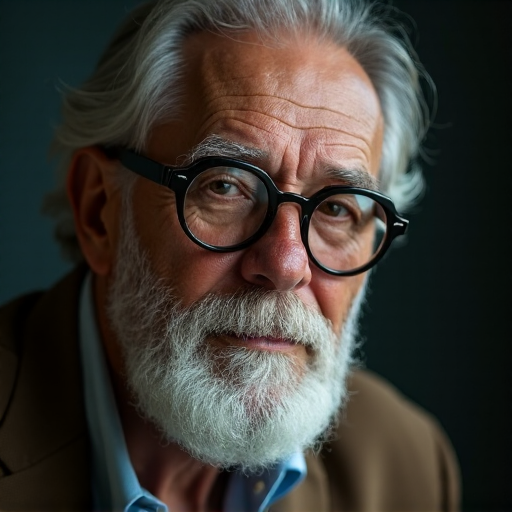

Processing prompt: A realistic, best quality, extremely detailed, ray tracing, photorealistic, A blue cat holding a sign that says hello world...


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output/flux-dev-4bit_1.png


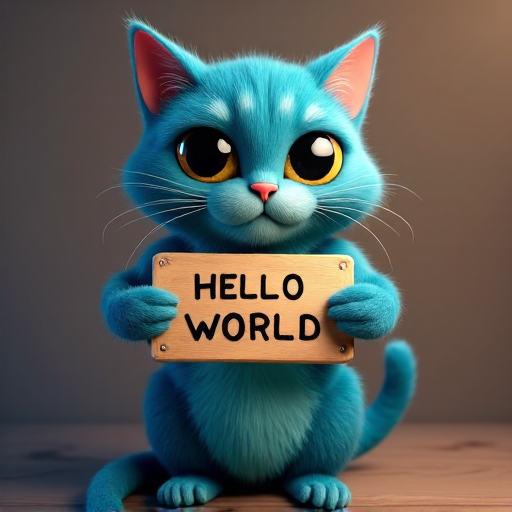

Processing prompt: A playful and photorealistic image of a golden retriever wearing a chef's hat and apron, standing at a kitchen counter making pizza. The counter is co...


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output/flux-dev-4bit_2.png


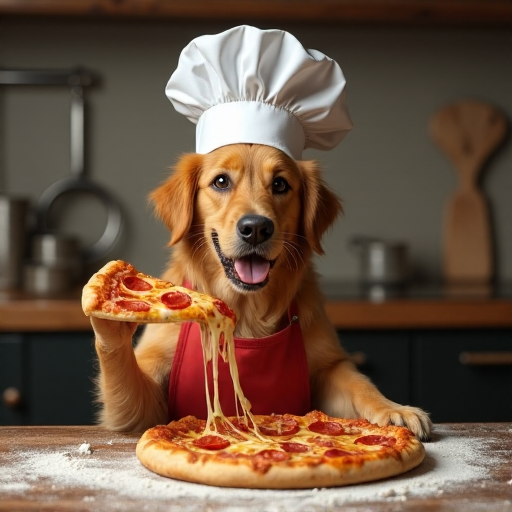

Processing prompt: A beautiful, anime-style portrait of a young girl with expressive eyes, wearing a futuristic astronaut helmet, vibrant orange and pink flowers surroun...


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output/flux-dev-4bit_3.png


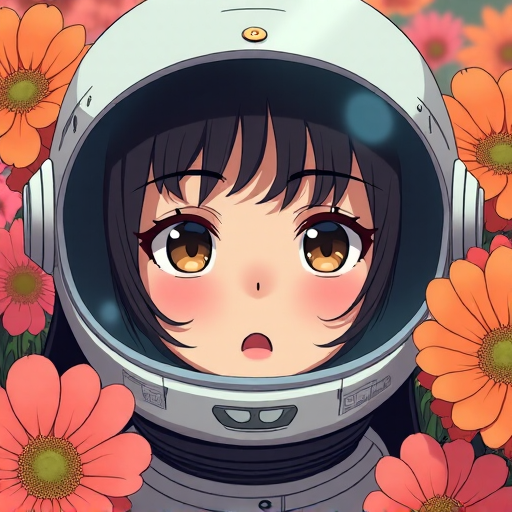

Processing prompt: A girl astronaut exploring the cosmos, floating among planets and stars, high quality detail, anime screencap, studio Ghibli style, illustration, high...


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output/flux-dev-4bit_4.png


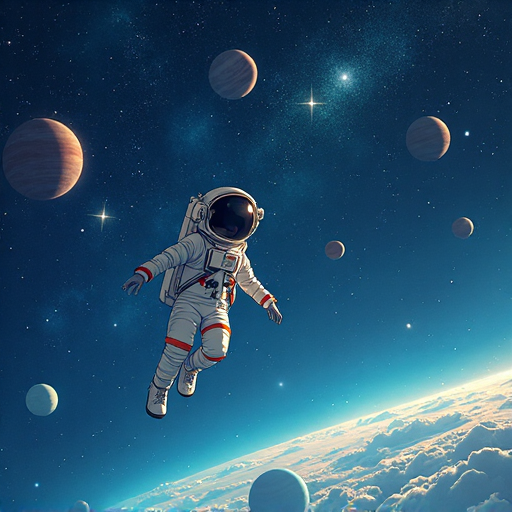

Processing prompt: Masterpiece, best quality, girl, collarbone, wavy hair, looking at viewer, blurry foreground, upper body, necklace, contemporary, plain pants, intrica...


  0%|          | 0/50 [00:00<?, ?it/s]

Saved to: output/flux-dev-4bit_5.png


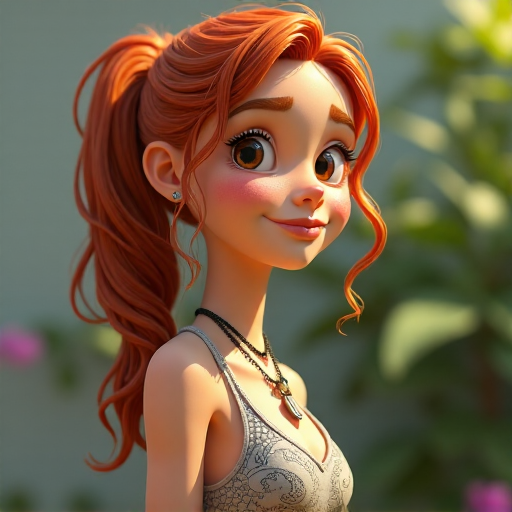

In [ ]:
import os
import torch
import typing
from diffusers import FluxPipeline
from IPython.display import display

from model import T5EncoderModel, FluxTransformer2DModel

def run_flux_pipeline_batch(
    prompts: typing.List[str],
    output_names: typing.List[str] = None,
    output_folder: str = "output",
    height: int = 512,
    width: int = 512,
    guidance_scale: float = 3.5,
    num_inference_steps: int = 50,
    max_sequence_length: int = 512,
    model_id="black-forest-labs/FLUX.1-dev",
    quant_model_id="HighCWu/FLUX.1-dev-4bit",
    seed: int = None,
):
    if output_folder and not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Load the model components once
    text_encoder_2 = T5EncoderModel.from_pretrained(
        quant_model_id,
        subfolder="text_encoder_2",
        torch_dtype=torch.bfloat16,
    )
    transformer = FluxTransformer2DModel.from_pretrained(
        quant_model_id,
        subfolder="transformer",
        torch_dtype=torch.bfloat16,
    )
    pipe = FluxPipeline.from_pretrained(
        model_id,
        text_encoder_2=text_encoder_2,
        transformer=transformer,
        torch_dtype=torch.bfloat16,
    )
    pipe.remove_all_hooks()
    pipe = pipe.to("cuda")
    pipe.enable_attention_slicing()
    pipe.enable_model_cpu_offload()

    # Ensure output_names matches prompts in length
    if output_names is None:
        output_names = [None] * len(prompts)

    for prompt, output_name in zip(prompts, output_names):
        print(f"Processing prompt: {prompt[:150]}...")  # Display part of the prompt for context

        image = pipe(
            prompt,
            height=height,
            width=width,
            guidance_scale=guidance_scale,
            output_type="pil",
            num_inference_steps=num_inference_steps,
            max_sequence_length=max_sequence_length,
            generator=torch.Generator("cpu").manual_seed(seed) if isinstance(seed, int) else None,
        ).images[0]

        if output_name:
            output_path = os.path.join(output_folder, output_name)
        else:
            output_files = len([f for f in os.listdir(output_folder) if f.endswith(".png")])
            output_name = f"flux-dev-4bit_{output_files}.png"
            output_path = os.path.join(output_folder, output_name)

        image.save(output_path)
        print(f"Saved to: {output_path}")

        # Display the image in the notebook
        display(image)

    # Release GPU memory after processing all prompts
    del text_encoder_2, transformer, pipe, image  # Delete model and image variables
    torch.cuda.empty_cache()  # Clear PyTorch CUDA cache

prompts = [
    "old man with glasses portrait, photo, 50mm, f1.4, natural light, Pathéchrome",
    "A realistic, best quality, extremely detailed, ray tracing, photorealistic, A blue cat holding a sign that says hello world",
    "A playful and photorealistic image of a golden retriever wearing a chef's hat and apron, standing at a kitchen counter making pizza. The counter is covered in flour, and the dog's paw is lifting a slice with melted cheese stretching. Include realistic fur texture and playful eyes.",
    "A beautiful, anime-style portrait of a young girl with expressive eyes, wearing a futuristic astronaut helmet, vibrant orange and pink flowers surrounding the helmet, surreal composition",
    "A girl astronaut exploring the cosmos, floating among planets and stars, high quality detail, anime screencap, studio Ghibli style, illustration, high contrast, masterpiece, best quality",
    "Masterpiece, best quality, girl, collarbone, wavy hair, looking at viewer, blurry foreground, upper body, necklace, contemporary, plain pants, intricate, print, pattern, ponytail, freckles, red hair, dappled sunlight, smile, happy",
]

run_flux_pipeline_batch(prompts=prompts)